In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from IPython.display import Markdown
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
N_SEED = 19
TOP_K = 5
VERBOSE = 1
N_JOBS = 4
COLOR_MAP = "RdYlBu"

np.random.seed(N_SEED)

In [3]:
dataset = pd.read_csv("../data/creditcard.csv")

In [4]:
dataset.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


## EDA

In [5]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
dataset.select_dtypes(include=["object"]).columns

Index([], dtype='object')

In [9]:
dataset.select_dtypes(include=["int64", "float64"]).columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [10]:
def show_corr(features, target):
    plt.figure(figsize=(19, 15))
    features.corrwith(target).plot.bar(color="purple", grid=True)
    ax = plt.gca()
    ax.spines["bottom"].set_color("brown")
    ax.spines["top"].set_color("brown")
    ax.spines["left"].set_color("brown")
    ax.spines["right"].set_color("brown")
    ax.tick_params(axis="x", colors="brown")
    ax.tick_params(axis="y", colors="brown")
    plt.show();

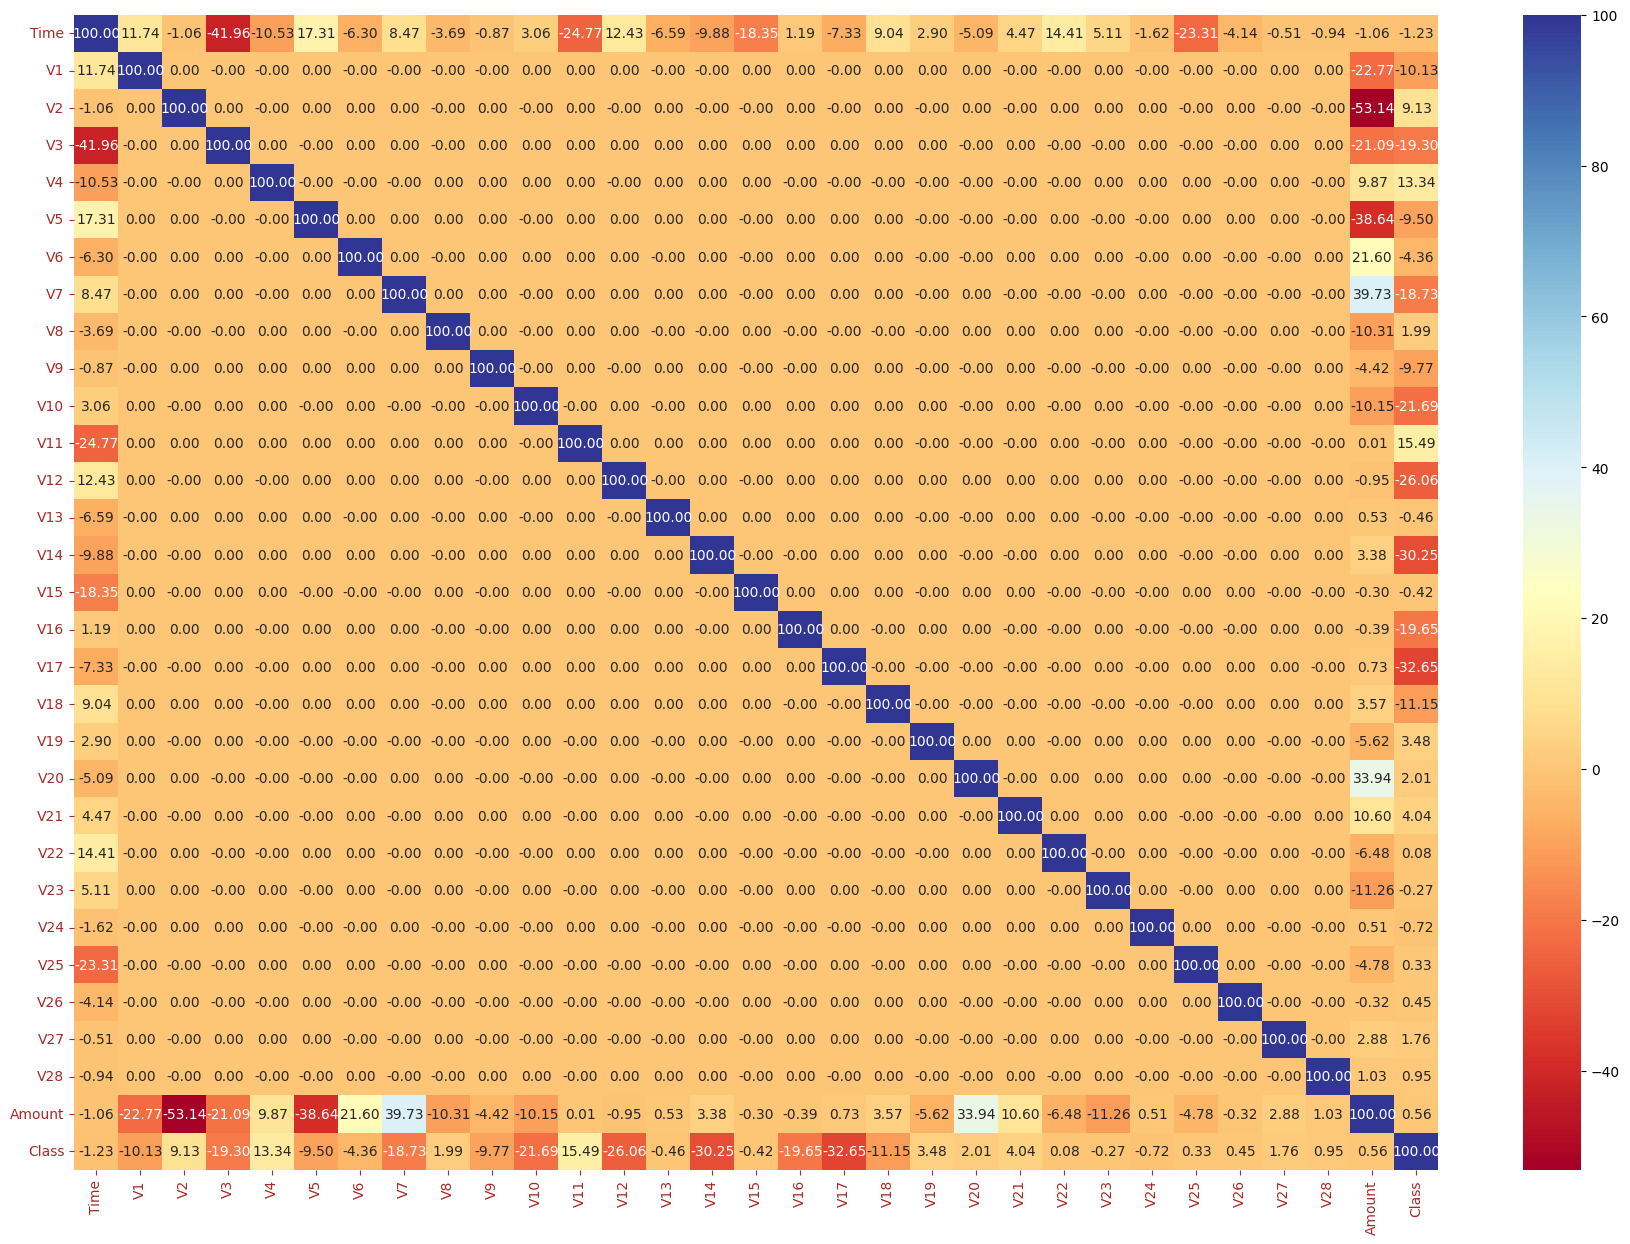

In [11]:
corr = dataset.corr() * 100
plt.figure(figsize=(22, 15))
sns.heatmap(corr, annot=True, cmap=COLOR_MAP, fmt=".2f")
ax = plt.gca()
ax.spines["bottom"].set_color("brown")
ax.spines["top"].set_color("brown")
ax.spines["left"].set_color("brown")
ax.spines["right"].set_color("brown")
ax.tick_params(axis="x", colors="brown")
ax.tick_params(axis="y", colors="brown")
plt.show();

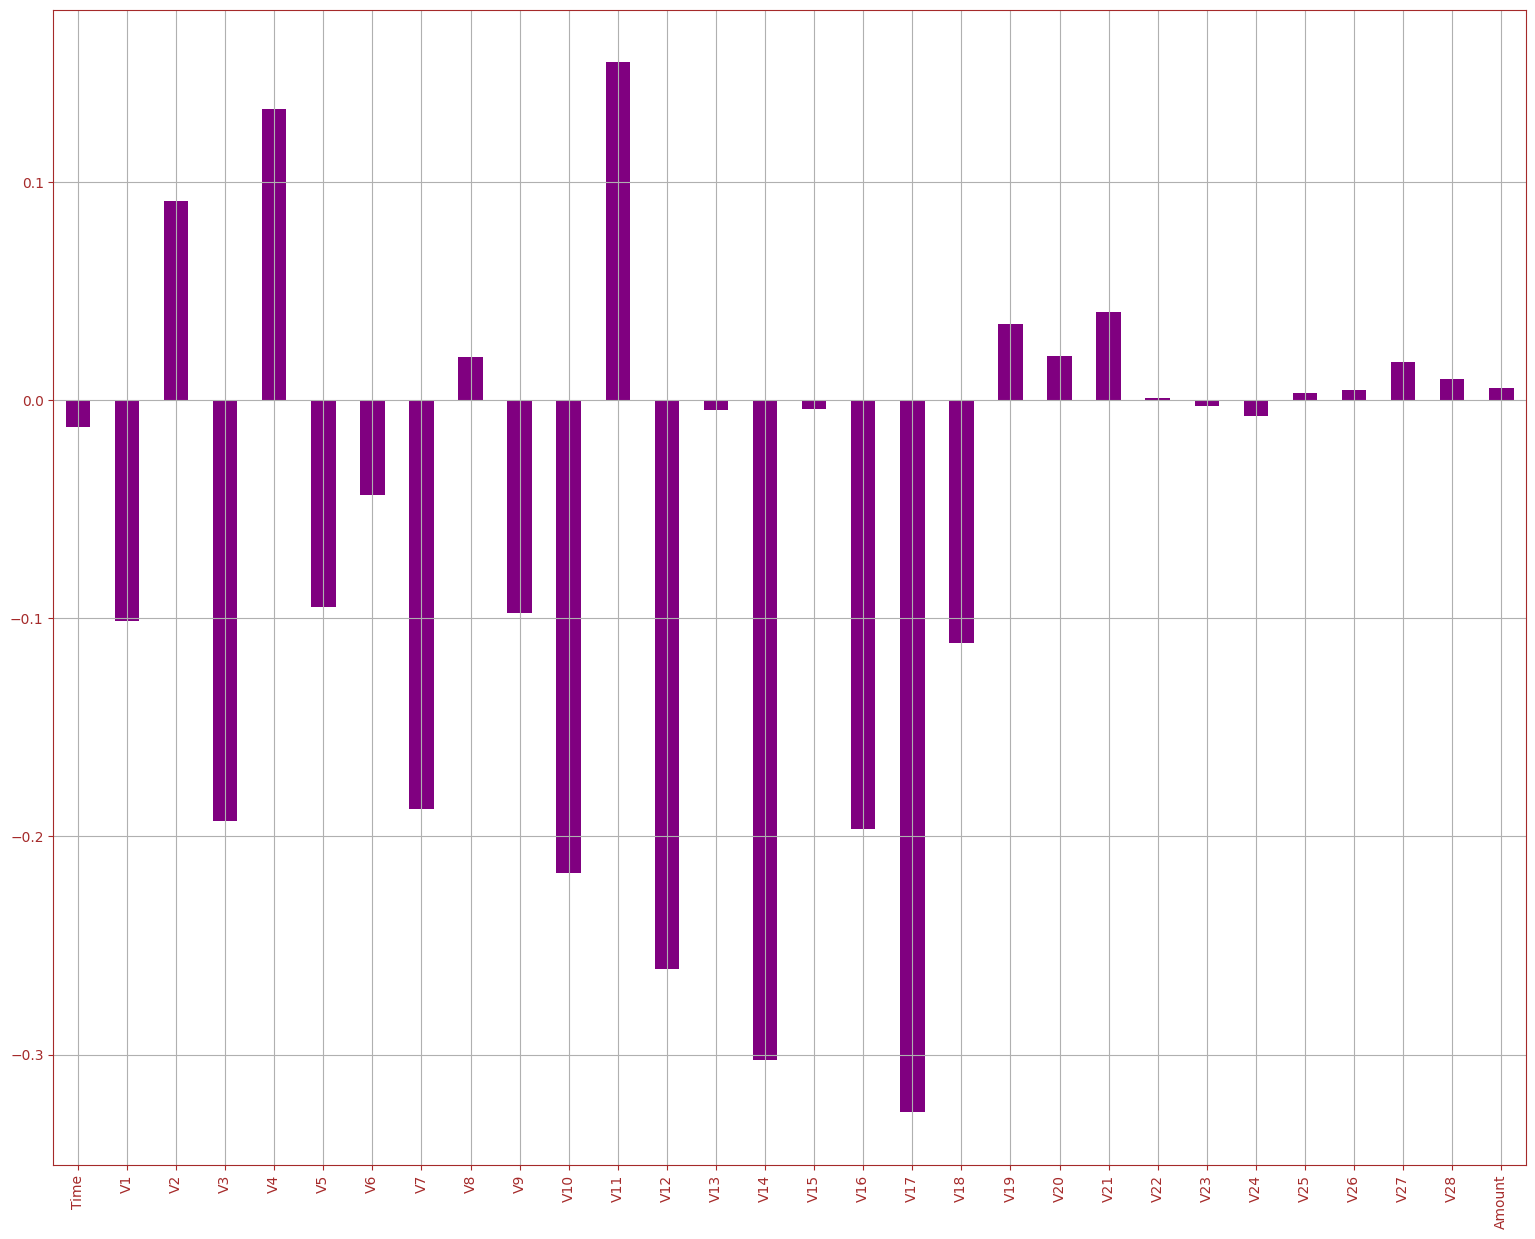

In [12]:
X_df = dataset.drop(columns=["Class"], axis=1)
# X_df_resized = X_df.drop(columns=["V13", "V15", "V22", "V23", "V24", "V25", "Amount"])
X_df_resized = X_df
y_df = dataset["Class"]
show_corr(X_df_resized, y_df)

In [13]:
X = np.array(X_df_resized)
y = np.array(y_df).reshape(-1, 1)

In [14]:
# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
_, counts = np.unique(y, return_counts=True)
class_ratio = counts[0]/counts[1]
class_ratio

np.float64(577.8760162601626)

In [16]:
L_FONT = {
    "color": "darkblue",
    "size": 11
}

T_COLOR = "darkred"


def plot_features(x, target):
    _, col = x.shape
    for i in range(col):
        plt.hist(x[:, i], color="green")
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Population", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();


def plot_class_dist(target):
    unique, counts = np.unique(target, return_counts=True)
    plt.bar(unique, counts, color="darkblue",)
    plt.xlabel("Class", fontdict=L_FONT)
    plt.ylabel("Population", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_xticks(ticks=unique, labels=unique)
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color="#1ecbe1", label="AUC = %0.4f" % roc_auc,)
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR", fontdict=L_FONT)
    plt.xlabel("FPR", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_title("Receiver Operating Characteristic", fontdict={"color": "darkblue"})
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_classification(y_true, y_pred):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    sns.heatmap(
        (precision*100, recall*100, f1*100),
        annot=True, cmap=COLOR_MAP,
        fmt=".4f",
        yticklabels=("precision", "recall", "f1")
    )
    ax = plt.gca()
    ax.set_title("Classification Report", fontdict=L_FONT)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();

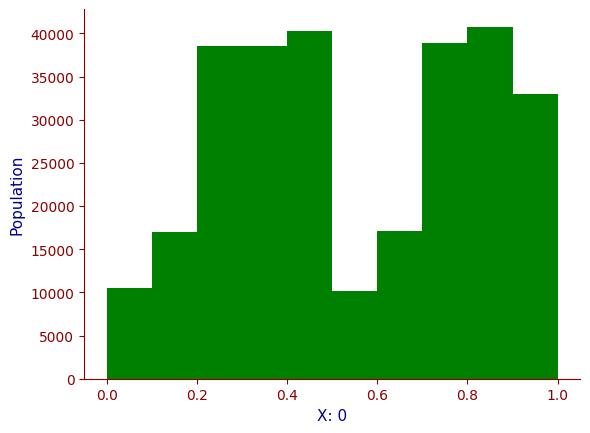

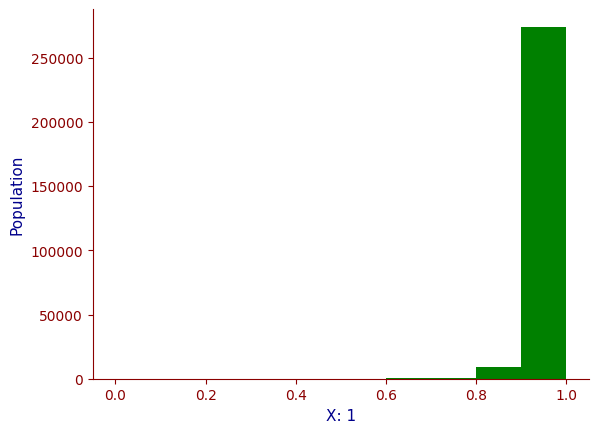

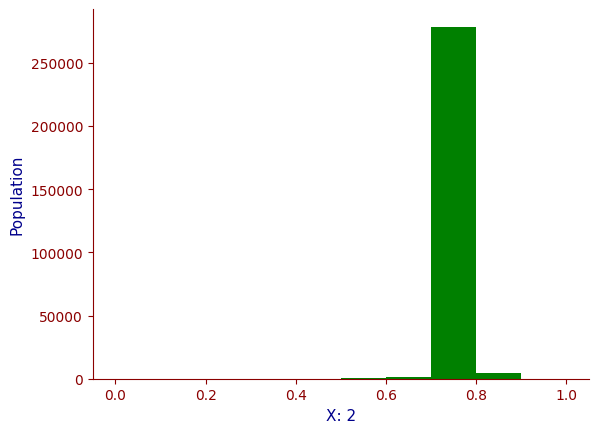

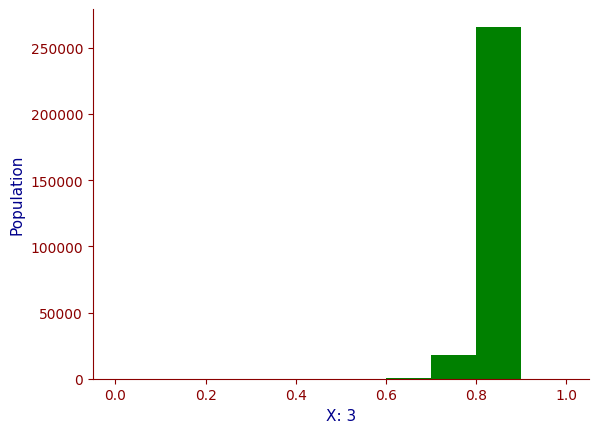

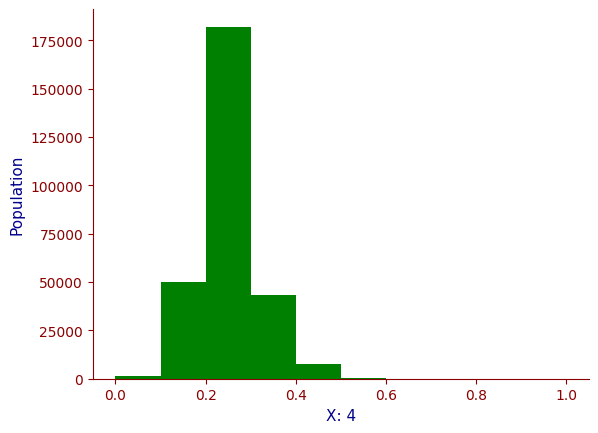

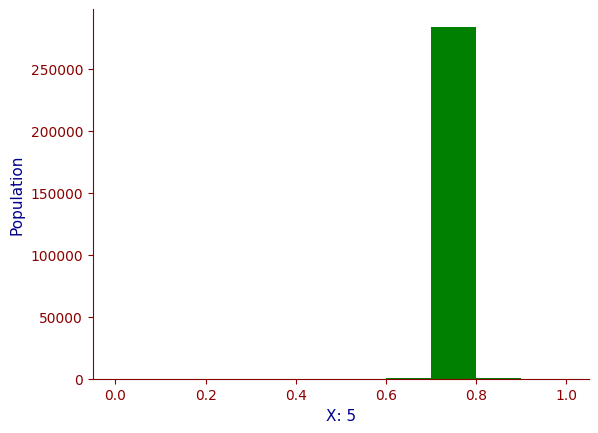

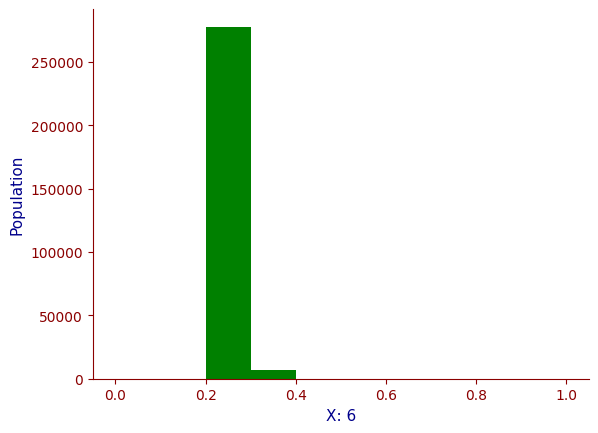

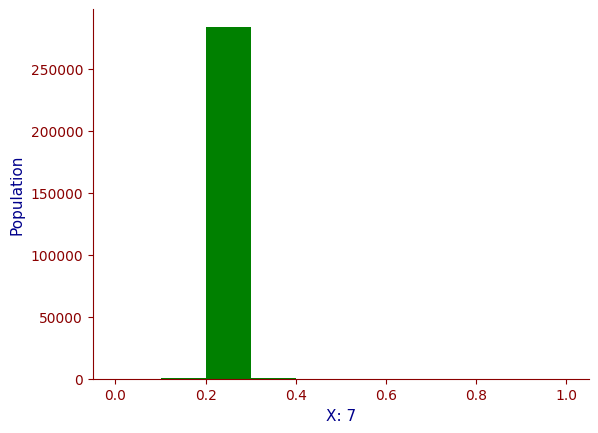

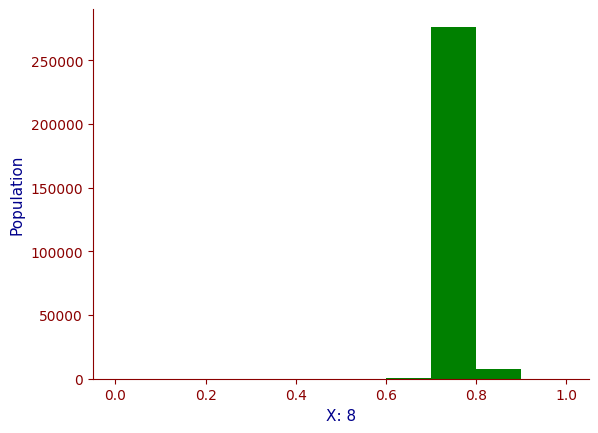

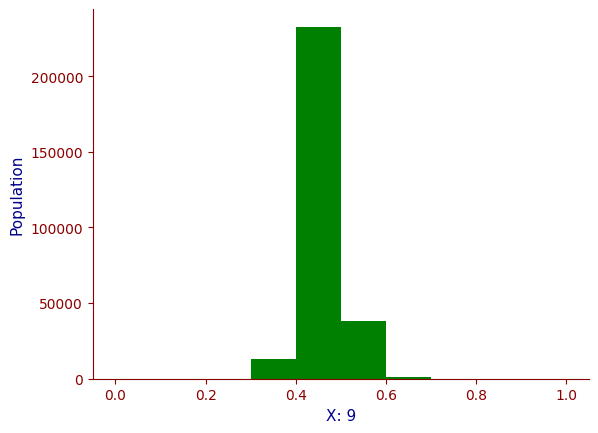

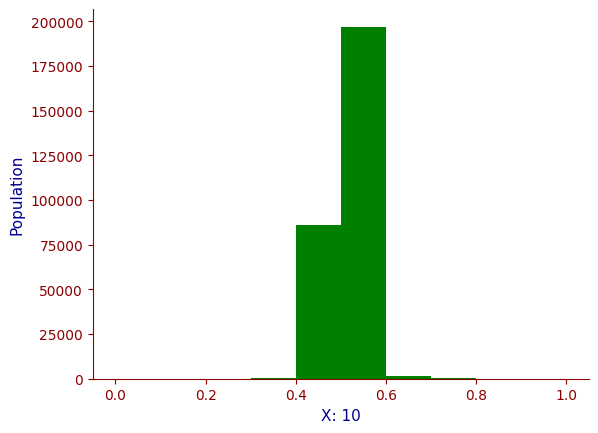

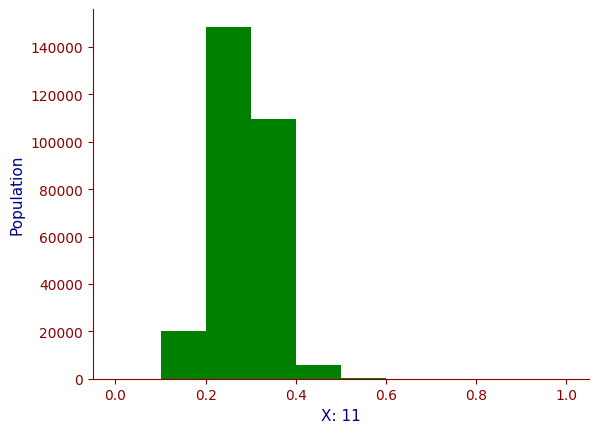

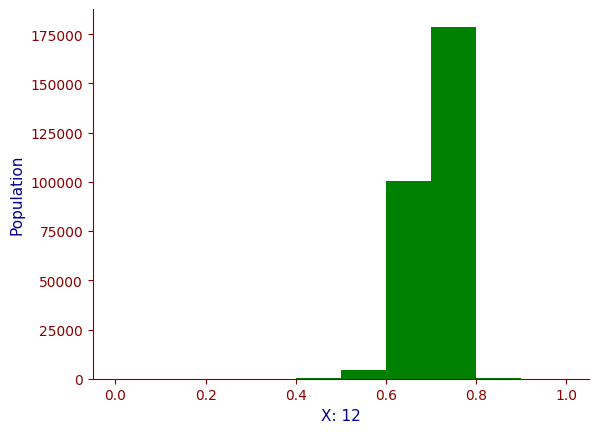

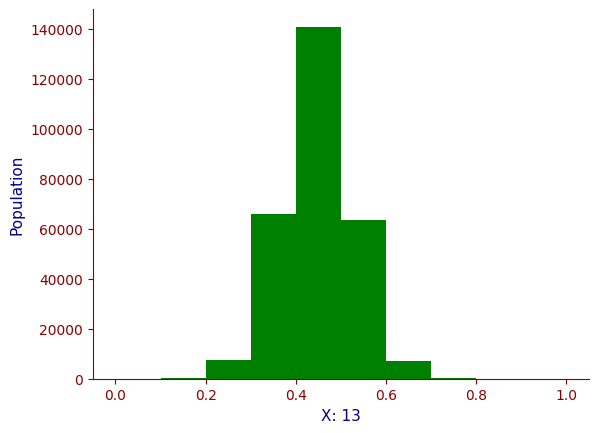

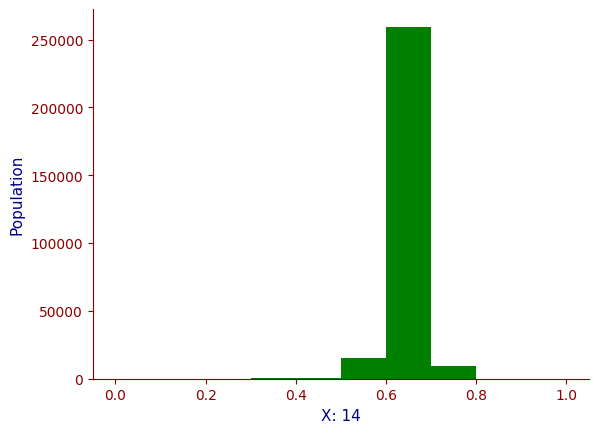

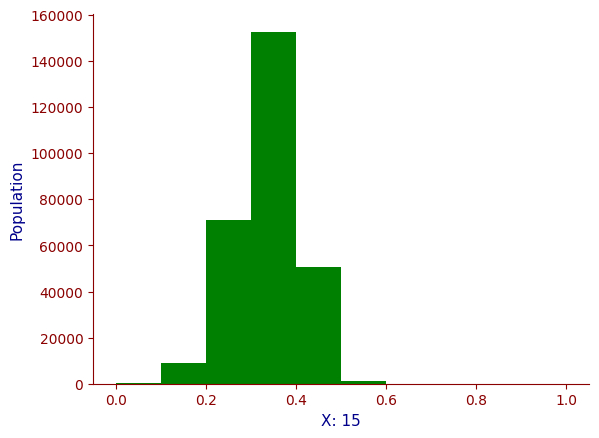

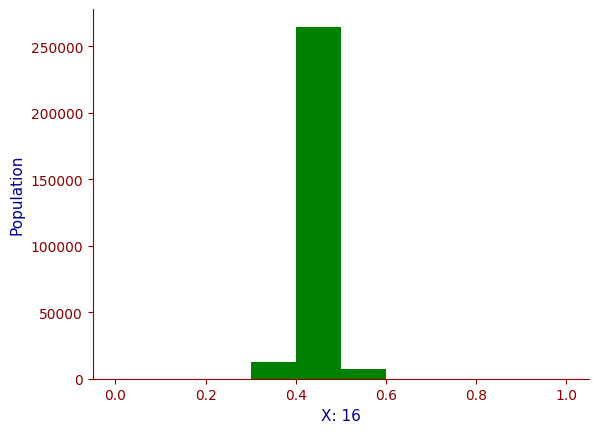

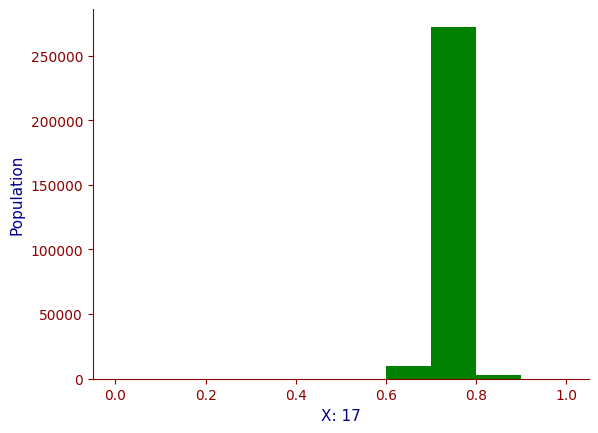

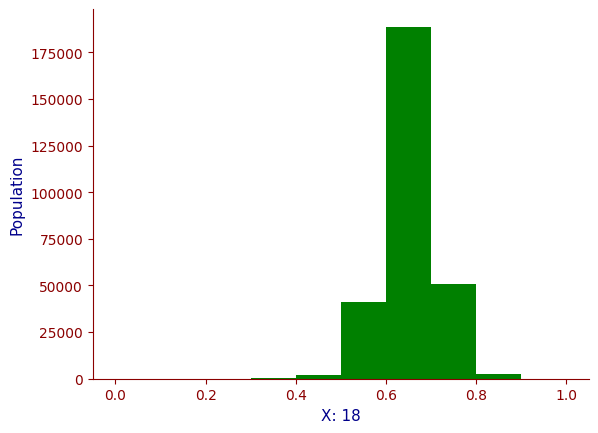

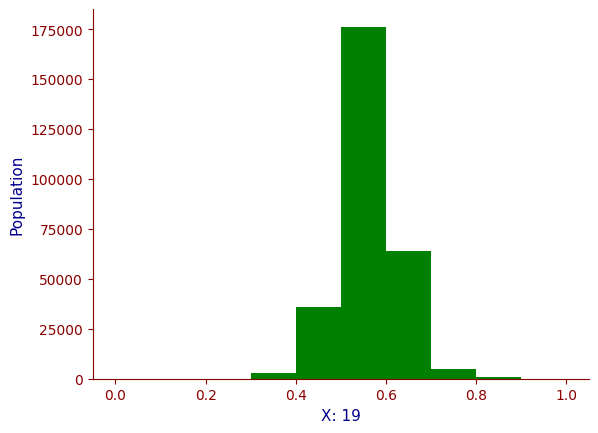

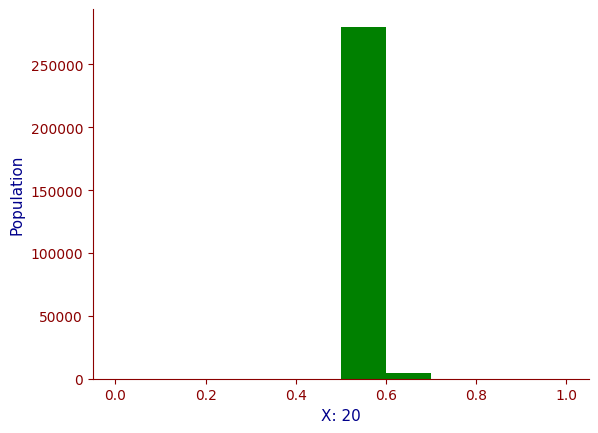

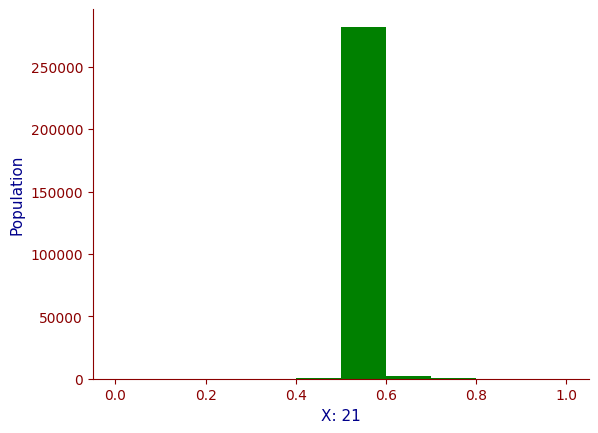

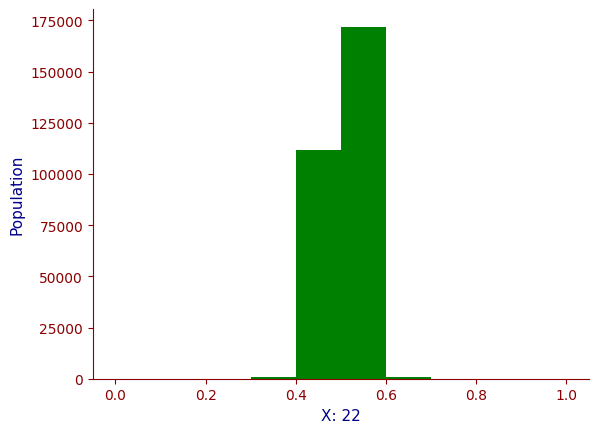

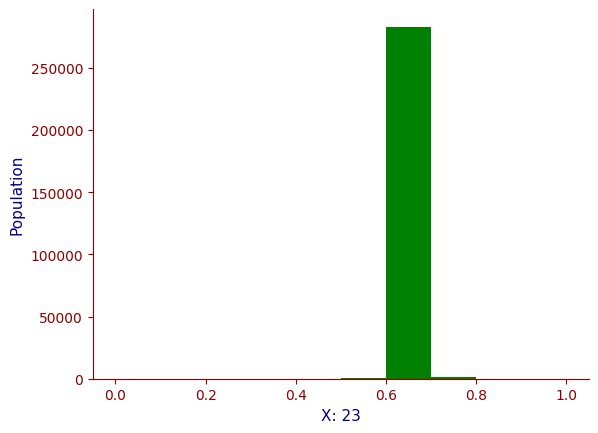

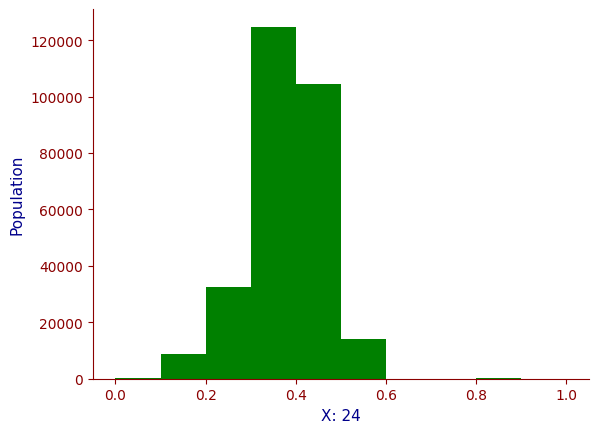

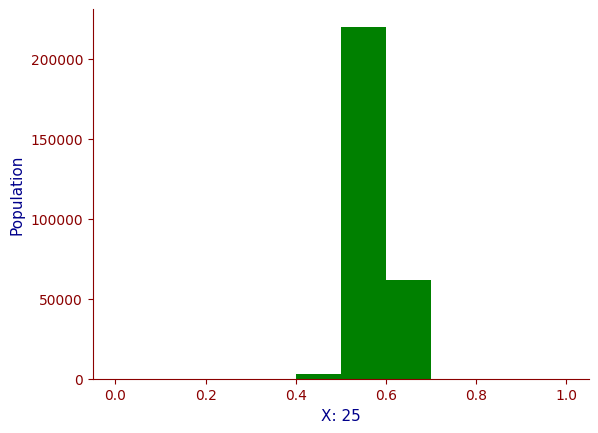

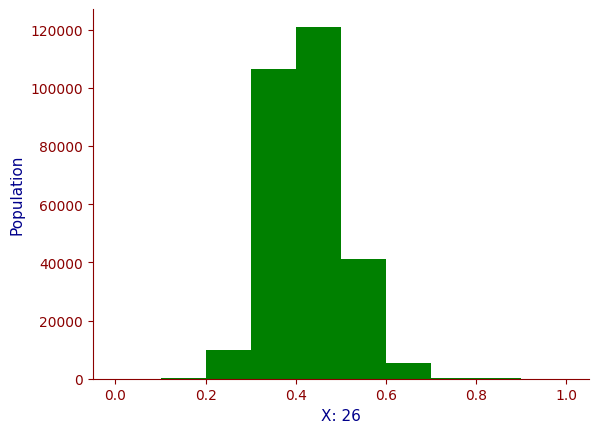

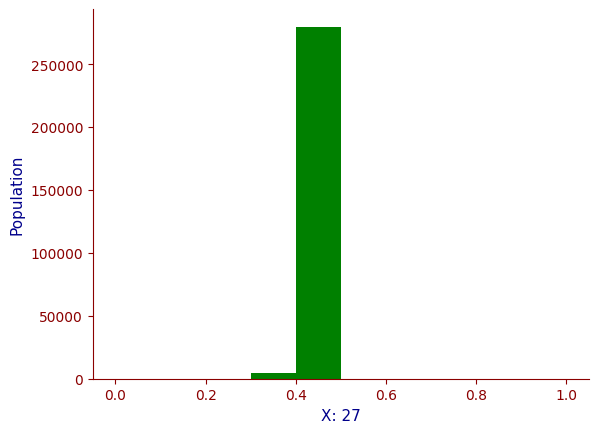

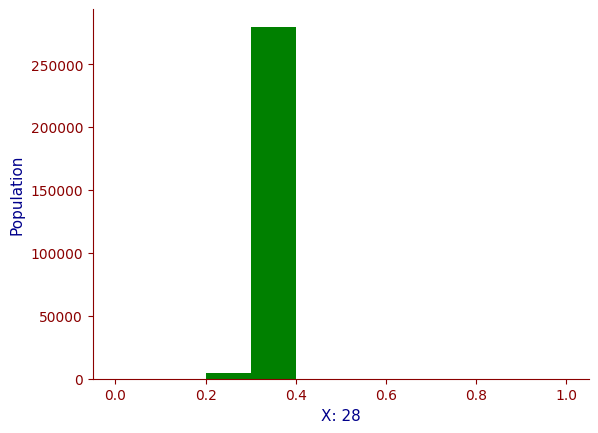

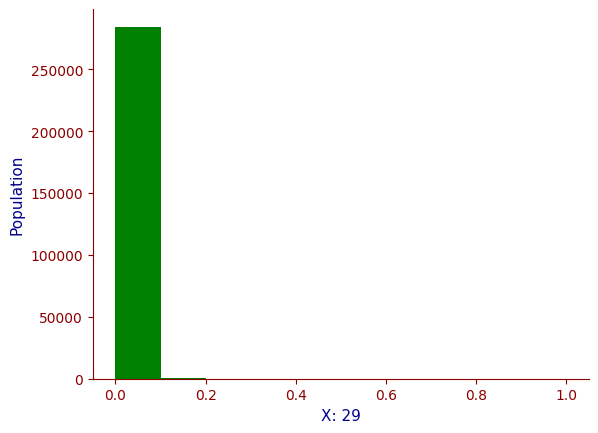

In [17]:
plot_features(X, y)

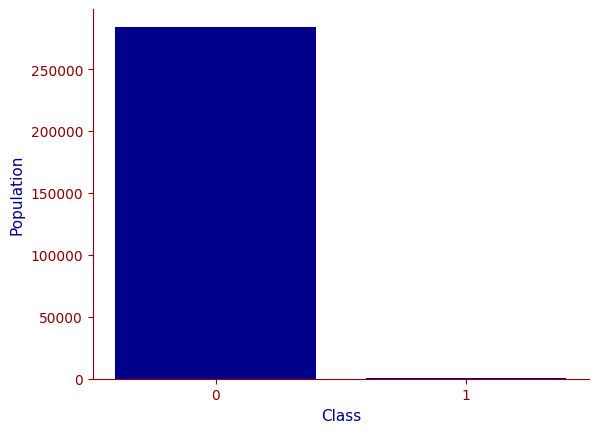

In [18]:
plot_class_dist(y)

In [19]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=N_SEED,
    shuffle=True,
    stratify=y
)

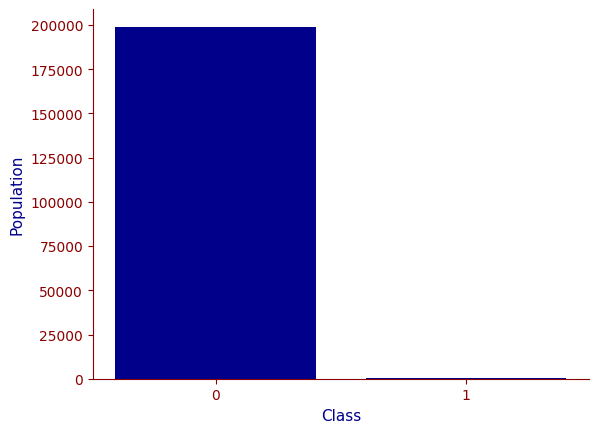

In [20]:
plot_class_dist(y0_train)

## Over Sampling train dataset

In [21]:
smote = SMOTE(
    sampling_strategy="minority",
    k_neighbors=5,
    random_state=N_SEED,
)

X_train, y_train = smote.fit_resample(X0_train, y0_train)
X_test, y_test = X0_test, y0_test

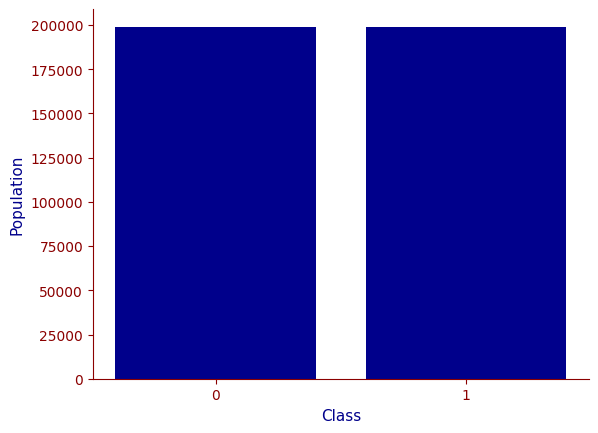

In [22]:
plot_class_dist(y_train)

## Logistic Regression

In [23]:
param_grid_LGR = {
    "solver": ["newton-cholesky"],
    "penalty": ["l2", None],
}

grid_search_cv_LGR = GridSearchCV(
    LogisticRegression(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_LGR,
    refit=True,
)

pipeline_LGR = make_pipeline(
    grid_search_cv_LGR,
)

pipeline_LGR.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(n_jobs=4,
                                                           random_state=19,
                                                           verbose=1),
                              param_grid={'penalty': ['l2', None],
                                          'solver': ['newton-cholesky']}))])

In [24]:
grid_search_cv_LGR.cv_results_

{'mean_fit_time': array([1.01782103, 0.90143981]),
 'std_fit_time': array([0.2601659 , 0.17541736]),
 'mean_score_time': array([0.00488038, 0.00415688]),
 'std_score_time': array([0.00132525, 0.00068487]),
 'param_penalty': masked_array(data=['l2', None],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_solver': masked_array(data=['newton-cholesky', 'newton-cholesky'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'penalty': 'l2', 'solver': 'newton-cholesky'},
  {'penalty': None, 'solver': 'newton-cholesky'}],
 'split0_test_score': array([0.94339765, 0.94786956]),
 'split1_test_score': array([0.94471661, 0.94903779]),
 'split2_test_score': array([0.94374937, 0.94828409]),
 'split3_test_score': array([0.94305849, 0.94805798]),
 'split4_test_score': array([0.94390011, 0.94868606]),
 'mean_test_score': array([0.94376445, 0.9483871 ]),
 'std_test_score': array([0.00055824, 

In [25]:
y_pred_LGR = pipeline_LGR.predict(X_test)
y_prob_LGR = pipeline_LGR.predict_proba(X_test) * 100
cm_LGR = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_LGR)

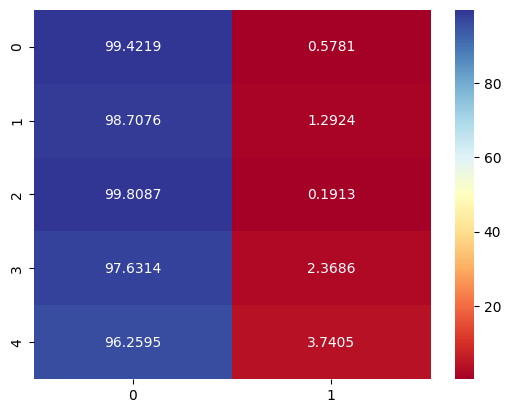

In [26]:
sns.heatmap(y_prob_LGR[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

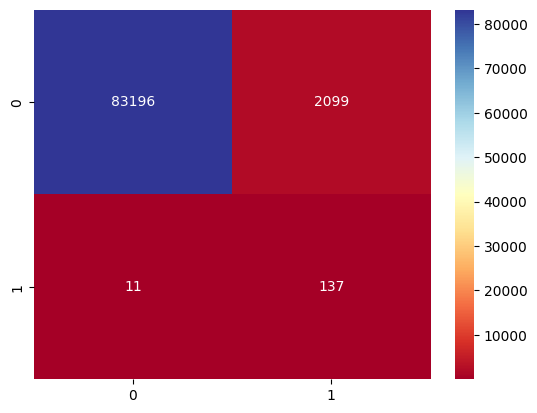

In [27]:
sns.heatmap(cm_LGR, annot=True, cmap=COLOR_MAP, fmt=".0f");

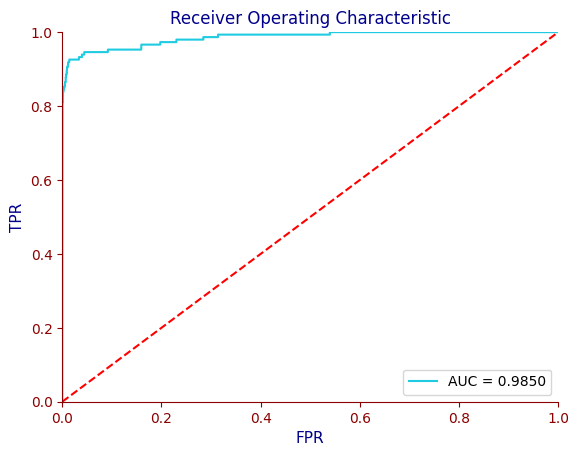

In [28]:
fpr_LGR, tpr_LGR, _ = metrics.roc_curve(y_test, y_prob_LGR[:, 1])
roc_auc_LGR = metrics.auc(fpr_LGR, tpr_LGR)
plot_roc(fpr_LGR, tpr_LGR, roc_auc_LGR)

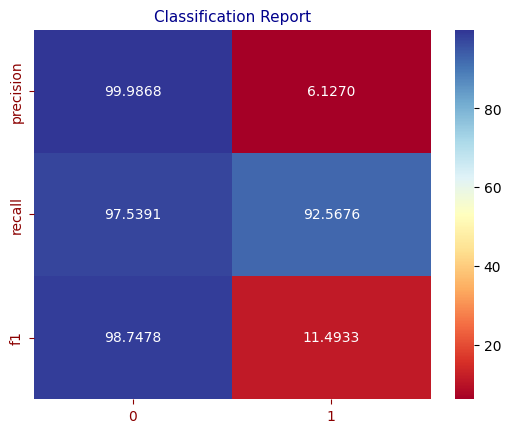

In [29]:
plot_classification(y_true=y_test, y_pred=y_pred_LGR)

In [30]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_LGR)

0.9753051742097071

## Random Forest Classifier

In [31]:
param_grid_RFC = {
}

grid_search_cv_RFC = GridSearchCV(
    RandomForestClassifier(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_RFC,
    refit=True,
)

pipeline_RFC = make_pipeline(
    grid_search_cv_RFC,
)

pipeline_RFC.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   42.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   47.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.7s
[Parallel(n_job

Newton iter=1
  Check Convergence
    1. max |gradient| 0.024549977852268125 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.015838409191840524 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.009439457513491355 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.004844463457550838 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.0021770357833955974 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.0009389510485810757 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00033938480777567 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 7.958374359923171e-05 <= 0.0001
    2. Newton decrement 0.00012758219668390126 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 1.0181923773045854e-05 <= 0.0001
    2. Newton decrement 1.4011320205842058e-05 <= 0.0001
  Solver did converge at loss = 0.14087834825359707.
Newton iter=1
  Check Convergence
    1. max |

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.1min finished


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=RandomForestClassifier(n_jobs=4,
                                                               random_state=19,
                                                               verbose=1),
                              param_grid={}))])

In [32]:
grid_search_cv_RFC.cv_results_

{'mean_fit_time': array([46.39585924]),
 'std_fit_time': array([1.91610557]),
 'mean_score_time': array([0.10648909]),
 'std_score_time': array([0.01396292]),
 'params': [{}],
 'split0_test_score': array([0.99991207]),
 'split1_test_score': array([0.99993719]),
 'split2_test_score': array([0.99991207]),
 'split3_test_score': array([0.99993719]),
 'split4_test_score': array([0.99977389]),
 'mean_test_score': array([0.99989448]),
 'std_test_score': array([6.13333113e-05]),
 'rank_test_score': array([1], dtype=int32)}

In [33]:
y_pred_RFC = pipeline_RFC.predict(X_test)
y_prob_RFC = pipeline_RFC.predict_proba(X_test) * 100
cm_RFC = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_RFC)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


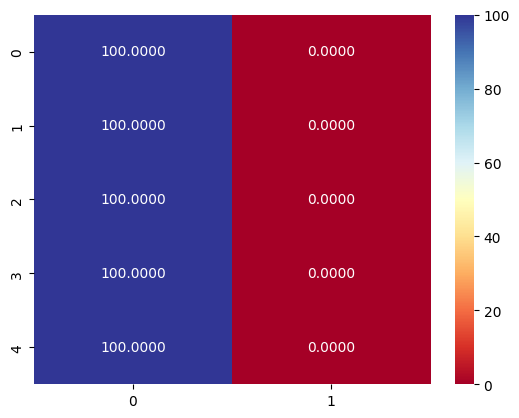

In [34]:
sns.heatmap(y_prob_RFC[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

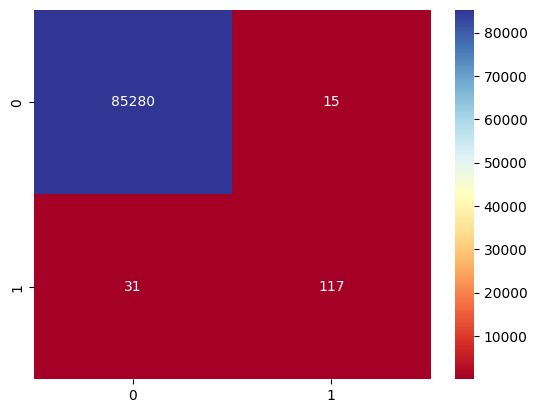

In [35]:
sns.heatmap(cm_RFC, annot=True, cmap=COLOR_MAP, fmt=".0f");

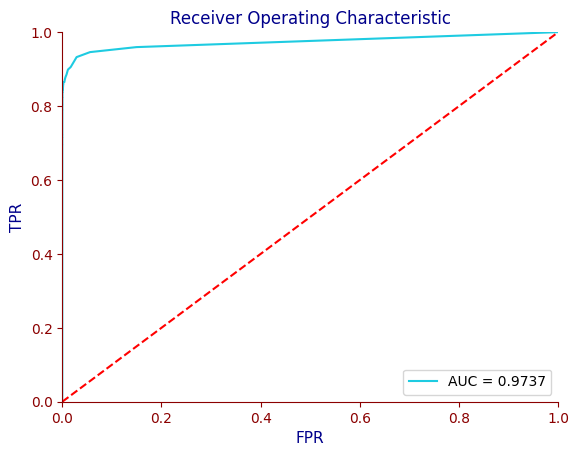

In [36]:
fpr_RFC, tpr_RFC, _ = metrics.roc_curve(y_test, y_prob_RFC[:, 1])
roc_auc_RFC = metrics.auc(fpr_RFC, tpr_RFC)
plot_roc(fpr_RFC, tpr_RFC, roc_auc_RFC)

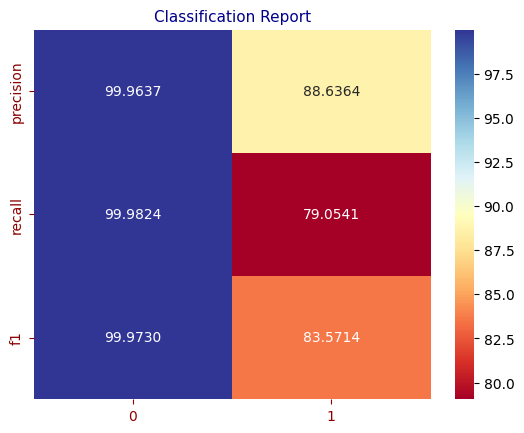

In [37]:
plot_classification(y_true=y_test, y_pred=y_pred_RFC)

In [38]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_RFC)

0.9994616293903538

## XGBoost

In [39]:
params_XGB = {
    "n_jobs": N_JOBS,
    "verbosity": VERBOSE,
}

param_grid_XGB = {
    "eta": [0.3, 0.5],
    "max_depth": [6, 8, 10]
}

model_XGB = XGBClassifier(**params_XGB)

grid_search_cv_XGB = GridSearchCV(
    model_XGB,
    param_grid=param_grid_XGB,
    refit=True,
)

pipeline_XGB = make_pipeline(
    grid_search_cv_XGB,
)

pipeline_XGB.fit(X_train, y_train)

Newton iter=1
  Check Convergence
    1. max |gradient| 0.024334662599447797 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.015281235386157058 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.009149622720431036 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.004884012917980752 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.002315639638549152 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.0010943446203221653 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.0005538706567751891 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.0001820462695491 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 0.00010739861572847719 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 4.165099310441409e-05 <= 0.0001
    2. Newton decrement 0.0001395347075295926 <= 0.0001
Newton iter=11
  Check Convergence
    1. max |gradient| 1.25404412972

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=4,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'eta': [0.3, 0.5],
                                          'max_depth': [6, 8, 10]}))])

In [40]:
grid_search_cv_XGB.cv_results_

{'mean_fit_time': array([1.06742997, 1.18978796, 1.26688628, 1.08815861, 1.16035523,
        1.16568027]),
 'std_fit_time': array([0.03086854, 0.02154224, 0.0199712 , 0.04045178, 0.05187982,
        0.0078332 ]),
 'mean_score_time': array([0.041541  , 0.07649045, 0.09833193, 0.05059743, 0.07329378,
        0.08126402]),
 'std_score_time': array([0.00056875, 0.00104767, 0.00765784, 0.00276501, 0.00083988,
        0.00114004]),
 'param_eta': masked_array(data=[0.3, 0.3, 0.3, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'param_max_depth': masked_array(data=[6, 8, 10, 6, 8, 10],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'eta': 0.3, 'max_depth': 6},
  {'eta': 0.3, 'max_depth': 8},
  {'eta': 0.3, 'max_depth': 10},
  {'eta': 0.5, 'max_depth': 6},
  {'eta': 0.5, 'max_depth': 8},
  {'eta': 0.5, 'max_depth': 10}],
 'split0_test_score': array([0.99986182, 0.99987438, 0.99982

In [41]:
y_pred_XGB = pipeline_XGB.predict(X_test)
y_prob_XGB = pipeline_XGB.predict_proba(X_test) * 100
cm_XGB = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_XGB)

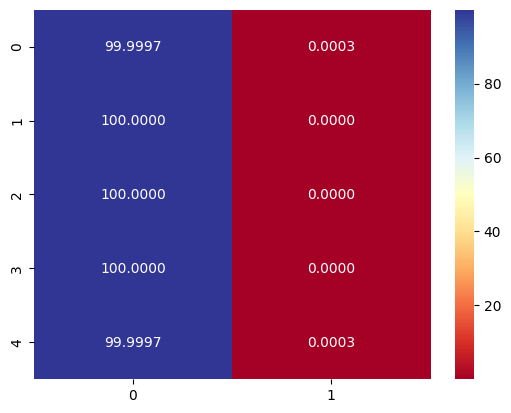

In [42]:
sns.heatmap(y_prob_XGB[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

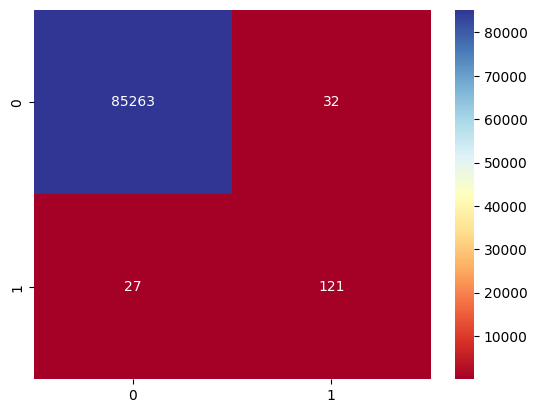

In [43]:
sns.heatmap(cm_XGB, annot=True, cmap=COLOR_MAP, fmt=".0f");

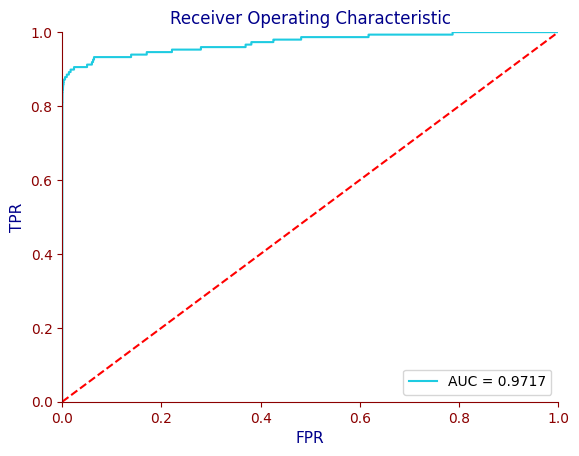

In [44]:
fpr_XGB, tpr_XGB, _ = metrics.roc_curve(y_test, y_prob_XGB[:, 1])
roc_auc_XGB = metrics.auc(fpr_XGB, tpr_XGB)
plot_roc(fpr_XGB, tpr_XGB, roc_auc_XGB)

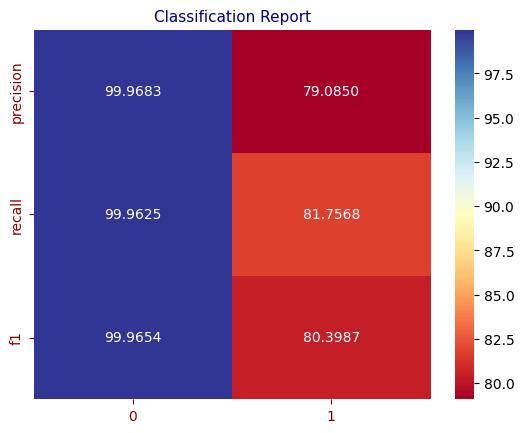

In [45]:
plot_classification(y_true=y_test, y_pred=y_pred_XGB)

In [46]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_XGB)

0.9993094811745842

## Artificial Neural Network

In [47]:
BATCH_SIZE = 30
NO_EPOCHS = 100
_, input_size = X.shape
print("Input size: {}".format(input_size))
HIDDEN_SIZE = 128
_, output_size = y.shape
print("Output size: {}".format(output_size))

Input size: 30
Output size: 1


In [48]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=N_SEED,
    shuffle=True,
    stratify=y
)

In [49]:
layers_ANN = [
    tf.keras.layers.Input(shape=(input_size,)),
    tf.keras.layers.Dense(
        units=HIDDEN_SIZE,
        activation="relu",
    ),
    tf.keras.layers.Dense(
        units=output_size,
        activation="sigmoid"
    ),
]

model_ANN = tf.keras.models.Sequential(layers_ANN)

In [50]:
optimizer_ANN = tf.optimizers.SGD(
        learning_rate=0.01,
        nesterov=True
)

model_ANN.compile(
    optimizer=optimizer_ANN,
    loss=tf.keras.losses.BinaryCrossentropy,
    metrics=["accuracy"],
)

model_ANN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model_ANN.fit(X1_train, y1_train, batch_size=BATCH_SIZE, epochs=NO_EPOCHS, verbose=VERBOSE,)

Epoch 1/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - accuracy: 0.9982 - loss: 0.0255
Epoch 2/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 237us/step - accuracy: 0.9983 - loss: 0.0115
Epoch 3/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - accuracy: 0.9981 - loss: 0.0125
Epoch 4/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - accuracy: 0.9984 - loss: 0.0102
Epoch 5/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - accuracy: 0.9982 - loss: 0.0117
Epoch 6/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 245us/step - accuracy: 0.9983 - loss: 0.0107
Epoch 7/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 242us/step - accuracy: 0.9983 - loss: 0.0105
Epoch 8/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 245us/step - accuracy: 0.9981 - loss: 0.0111
Epoch 9/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step - accuracy: 0.9981 - loss: 0.0111
Epoch 10/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step - accuracy: 0.9983 - loss: 0.0097
Epoch 11/100
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step - accuracy: 0.9983 - loss: 0.00

In [52]:
loss_ANN, accuracy_ANN = model_ANN.evaluate(X1_test, y1_test)
loss_ANN, accuracy_ANN

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 213us/step - accuracy: 0.9990 - loss: 0.0046


(0.003792953910306096, 0.9991690516471863)

In [53]:
y_proba_ANN = model_ANN.predict(X1_test)
y_pred_ANN = y_proba_ANN.round()

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 206us/step


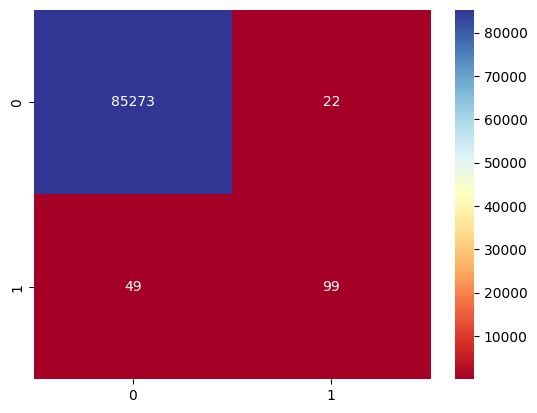

In [54]:
cm_ANN = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_ANN)
sns.heatmap(cm_ANN, annot=True, cmap=COLOR_MAP, fmt=".0f");

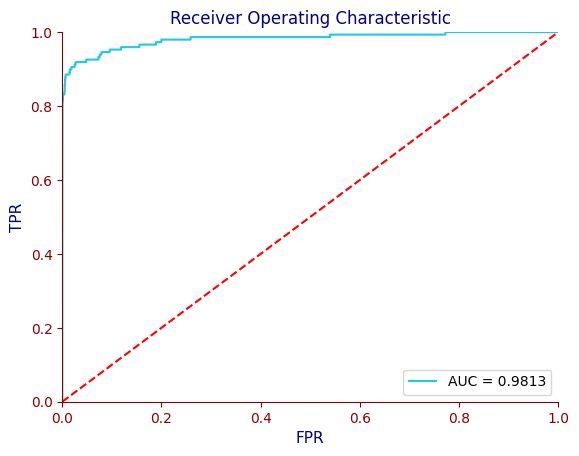

In [55]:
fpr_ANN, tpr_ANN, _ = metrics.roc_curve(y_test, y_proba_ANN)
roc_auc_ANN = metrics.auc(fpr_ANN, tpr_ANN)
plot_roc(fpr_ANN, tpr_ANN, roc_auc_ANN)

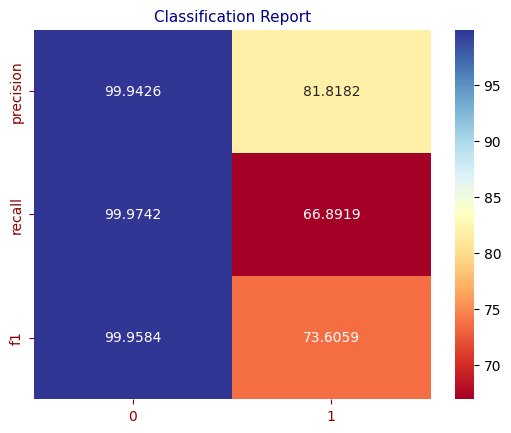

In [56]:
plot_classification(y_true=y_test, y_pred=y_pred_ANN)